<a href="https://colab.research.google.com/github/leonorsilva/projecto/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertForSequenceClassification

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        #self.pos_embedding = nn.Embedding(max_length, hid_dim)  #position embedding

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim]))  #.to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        #pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale)) #+ self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:

            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]
        output = self.fc_out(src)
        output = torch.softmax(torch.mean(output, 1),1)

        return output



In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])) #.to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)


        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
INPUT_DIM = 15000
OUTPUT_DIM = 5
HID_DIM = 4
ENC_LAYERS = 1
ENC_HEADS = 2
ENC_PF_DIM = 3
ENC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              OUTPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
token= tokenizer.encode_plus('I am awesome', max_length=5, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')

In [ ]:
input=torch.Tensor(token['input_ids'].numpy())
input=input.type(torch.int32)

mask=torch.Tensor(token['attention_mask'].numpy())
mask=mask.type(torch.int32)

In [ ]:
input2=torch.Tensor([token['input_ids'].numpy()[0],token['input_ids'].numpy()[0]])
input2=input2.type(torch.int32)


mask2=torch.Tensor([token['attention_mask'].numpy()[0],token['attention_mask'].numpy()[0]])
mask2=mask2.type(torch.int32)

In [ ]:
input

tensor([[  101,   146,  1821, 14918,   102]], dtype=torch.int32)

In [ ]:
mask

tensor([[1, 1, 1, 1, 1]], dtype=torch.int32)

In [ ]:
mask=(input != mask).unsqueeze(1).unsqueeze(2)

In [ ]:
enc(input,mask)

tensor([[0.0707, 0.1008, 0.2612, 0.3849, 0.1824]], grad_fn=<SoftmaxBackward0>)

In [ ]:
mask2=(input2 != mask2).unsqueeze(1).unsqueeze(2)

In [ ]:
mask2

tensor([[[[True, True, True, True, True]]],


        [[[True, True, True, True, True]]]])

In [ ]:
enc(input2,mask2)

tensor([[0.0671, 0.0905, 0.2430, 0.4058, 0.1936],
        [0.0948, 0.1305, 0.2463, 0.3122, 0.2162]], grad_fn=<SoftmaxBackward0>)

TRAIN

In [92]:
import pandas as pd

train=pd.DataFrame(pd.read_csv('train.tsv',sep='\t'))

In [93]:
train['tokens']=None
train['mask']=None

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, phrase in enumerate(train['Phrase']):
    tokens = tokenizer.encode_plus(phrase, max_length=50, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # assign tokenized outputs to respective rows in numpy arrays
    train['tokens'][i]=tokens['input_ids'].numpy()[0].tolist()
    train['mask'][i]=tokens['attention_mask'].numpy()[0].tolist()


<ipython-input-94-aa977f2eeb4b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tokens'][i]=tokens['input_ids'].numpy()[0].tolist()
<ipython-input-94-aa977f2eeb4b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mask'][i]=tokens['attention_mask'].numpy()[0].tolist()


In [ ]:
#train=pd.get_dummies(train, columns =['Sentiment'])

In [77]:
train

,PhraseId,SentenceId,Phrase,Sentiment,tokens,mask
0,1,1,A series of escapades demonstrating the adage ...,1,"[101, 138, 1326, 1104, 13936, 25265, 16913, 15...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,1,A series of escapades demonstrating the adage ...,2,"[101, 138, 1326, 1104, 13936, 25265, 16913, 15...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,3,1,A series,2,"[101, 138, 1326, 102, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,1,A,2,"[101, 138, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1,series,2,"[101, 1326, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
156055,156056,8544,Hearst 's,2,"[101, 22038, 2050, 112, 188, 102, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
156056,156057,8544,forced avuncular chortles,1,"[101, 2257, 170, 25247, 26405, 5552, 22572, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
156057,156058,8544,avuncular chortles,3,"[101, 170, 25247, 26405, 5552, 22572, 12148, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
156058,156059,8544,avuncular,2,"[101, 170, 25247, 26405, 5552, 102, 0, 0, 0, 0...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [89]:
input=torch.Tensor([train['tokens'][0]])
mask=torch.Tensor([train['mask'][0]])

input=input.type(torch.int32)
mask=mask.type(torch.int32)

In [90]:
mask=(input != mask).unsqueeze(1).unsqueeze(2)

In [91]:
mask

tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True, False, False, False, False, False, False]]]])

In [ ]:
INPUT_DIM = 30000
OUTPUT_DIM = 5
HID_DIM = 512
ENC_LAYERS = 1
ENC_HEADS = 2
ENC_PF_DIM = 3
ENC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              OUTPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

NameError: ignored

In [ ]:
enc(input,mask)

tensor([[0.2460, 0.1522, 0.1695, 0.1631, 0.2692]], grad_fn=<SoftmaxBackward0>)

In [ ]:
data=train.sample(4)  #with repetition

inputs= torch.Tensor(np.vstack(data['tokens']))
masks=torch.Tensor(np.vstack(data['mask']))

inputs=inputs.type(torch.int32)
masks=masks.type(torch.int32)

masks=(inputs != masks).unsqueeze(1).unsqueeze(2)

In [ ]:
enc(inputs,masks)

tensor([[0.2799, 0.1181, 0.2345, 0.1246, 0.2428],
        [0.3526, 0.0812, 0.2340, 0.1227, 0.2095],
        [0.2543, 0.1082, 0.2364, 0.1304, 0.2706],
        [0.2711, 0.1278, 0.2221, 0.1229, 0.2561]], grad_fn=<SoftmaxBackward0>)

<Axes: >

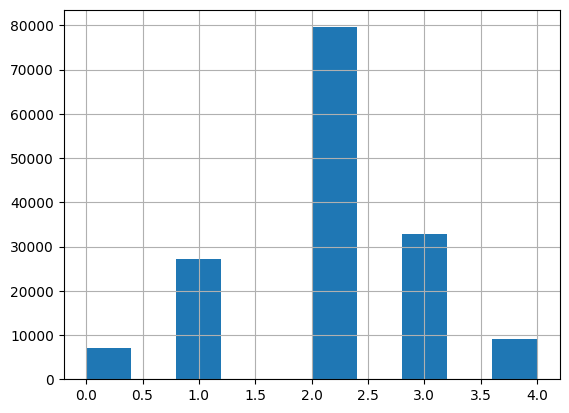

In [12]:
train['Sentiment'].hist()


In [95]:
import sklearn
from sklearn.utils.class_weight import compute_sample_weight

y = train['Sentiment']
train['weigth']=compute_sample_weight(class_weight='balanced', y=y)

In [96]:
train.to_csv('train.csv')

Default transformer

In [84]:
import ast

def from_np_array(array_string):
    #array_string = ','.join(array_string.replace('\n',' ').split())
    #print(array_string)
    return np.array(ast.literal_eval(array_string))

In [88]:
train=pd.read_csv('t.csv', converters={'mask': from_np_array , 'tokens': from_np_array})

<Axes: >

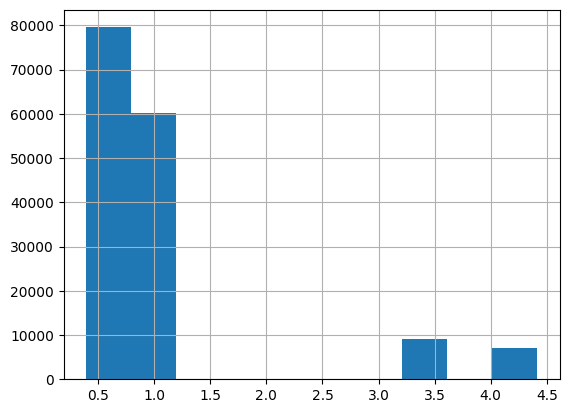

In [15]:
 train['weigth'].hist()

In [16]:
class transformer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 max_length = 100):
        super().__init__()


        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        #self.pos_embedding = nn.Embedding(max_length, hid_dim)  #position embedding

        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=hid_dim, nhead=n_heads)
                                     for _ in range(n_layers)])


        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim]))  #.to(device)

    def forward(self, src):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        #pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale)) #+ self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]


        for layer in self.layers:

            src = layer(src)

        #src = [batch size, src len, hid dim]
        output = self.fc_out(src)
        output = torch.softmax(torch.mean(output, 1),1)

        return output



In [ ]:
import torch.optim as optim
import torch.nn.functional as F

INPUT_DIM = 30000
OUTPUT_DIM = 5
HID_DIM = 512
ENC_LAYERS = 6
ENC_HEADS = 16
ENC_PF_DIM = 3
ENC_DROPOUT = 0.1

trans = transformer(INPUT_DIM,
              OUTPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT)




def trainning(epoch):
    running_loss = 0.
    last_loss = 0.
    batch=256
    losses=[]
    optimizer = optim.Adam(trans.parameters(), lr=0.01)

    for i in range(epoch):
        # Every data instance is an input + label pair
        data=train.sample(batch,weights = train['weigth'])  #with repetition

        inputs= torch.Tensor(np.vstack(data['tokens']))
        masks=torch.Tensor(np.vstack(data['mask']))

        inputs=inputs.type(torch.int32)
        masks=masks.type(torch.int32)

        masks=(inputs != masks).unsqueeze(1).unsqueeze(2)

        labels=torch.FloatTensor(data['Sentiment'].to_numpy())
        labels=labels.type(torch.int64)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = trans(inputs)
        print(outputs)
        print(labels)
        # Compute the loss and its gradients
        loss = F.cross_entropy(outputs, labels)
        losses.append(loss.detach().numpy())
        loss.backward()

        # Adjust learning weights
        optimizer.step()



    return losses

losses=trainning(20)
plt.plot(losses)

tensor([[0.1998, 0.1751, 0.1848, 0.2677, 0.1726],
        [0.2036, 0.1539, 0.2209, 0.2814, 0.1401],
        [0.2135, 0.1496, 0.2205, 0.2672, 0.1492],
        ...,
        [0.2241, 0.1399, 0.2252, 0.2912, 0.1197],
        [0.2065, 0.1603, 0.2123, 0.2872, 0.1336],
        [0.2051, 0.1643, 0.1892, 0.2835, 0.1580]], grad_fn=<SoftmaxBackward0>)
tensor([4, 4, 4, 4, 4, 3, 2, 1, 1, 3, 0, 2, 2, 0, 4, 1, 3, 4, 4, 1, 0, 0, 1, 2,
        1, 2, 0, 3, 0, 4, 3, 2, 2, 3, 0, 4, 1, 4, 1, 2, 3, 0, 4, 1, 2, 2, 0, 1,
        4, 3, 4, 1, 4, 4, 3, 0, 4, 4, 4, 2, 2, 4, 3, 3, 4, 2, 1, 2, 4, 1, 0, 3,
        1, 4, 4, 0, 4, 3, 1, 3, 3, 0, 4, 4, 0, 2, 0, 3, 2, 2, 2, 2, 3, 0, 4, 2,
        0, 3, 4, 0, 2, 2, 2, 1, 4, 4, 0, 1, 1, 1, 4, 2, 0, 3, 4, 0, 3, 2, 1, 2,
        2, 0, 2, 1, 3, 4, 2, 4, 1, 0, 0, 0, 0, 4, 2, 4, 4, 4, 0, 0, 2, 3, 2, 2,
        1, 4, 2, 0, 3, 0, 1, 3, 3, 2, 1, 3, 0, 1, 0, 2, 0, 3, 2, 1, 0, 4, 4, 1,
        4, 2, 2, 2, 4, 3, 1, 1, 3, 0, 4, 3, 3, 2, 3, 0, 4, 2, 2, 4, 3, 0, 1, 1,
        1, 0, 3, 4